In [1]:
#to moun the google drive
from google.colab import drive
drive.mount('/content/drive')



ModuleNotFoundError: No module named 'google'

In [3]:
#TO import data from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [4]:
#to authenticate google drive account
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [5]:
#Bring file in /content/ from google drive
#https://drive.google.com/open?id=1lZYdxyO5pFFHvjxdFtGA8m9WS9haUHG5
#https://drive.google.com/open?id=1a3p1KL3egwoR76t90PaMdtszh_USRoPq
downloaded = drive.CreateFile({'id':"17yK0Igt-9G8o4iIuXxw8UeQHfPx0cJGs"})   # replace the id with id of file you want to access
downloaded.GetContentFile('Data.zip')        # replace the file name with your file

In [6]:

#Unzipping the files
!unzip -q "/content/Data.zip"

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import confusion_matrix
import os

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
def load_checkpoint(filepath):

    #checkpoint = torch.load(filepath,map_location='cpu') #unka
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    
    #model.load_state_dict(checkpoint['state_dict'])
    model = models.resnet34(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']
    
    return model

In [10]:
test_transforms = transforms.Compose([transforms.Resize((244,244)),
                                      transforms.ToTensor(),])
test_dir = '/content/Data/Test'
test_dataset =  datasets.ImageFolder(test_dir,transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)

In [11]:
def Cal_Accuracy(model):
  correct = 0
  total = 0
  model = model.to(device)
  predlist=torch.zeros(0,dtype=torch.long,device=device)
  lbllist=torch.zeros(0,dtype=torch.long,device=device)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()
        # Append batch prediction results
        predlist=torch.cat([predlist,predicted_outcome.view(-1)])
        lbllist=torch.cat([lbllist,labels.view(-1)])

  conf_mat=confusion_matrix(lbllist.cpu().numpy(), predlist.cpu().numpy())
  Acc = round(100 * correct / total,3)
  return Acc, conf_mat

In [12]:
model_name = "modelFinal"
path = "/content/drive/My Drive/Colab Notebooks/model/"+model_name+".pth"
model = load_checkpoint(path)
accuracy , matrix = (Cal_Accuracy(model))
print("Accuracy:",accuracy,"%")
print("matrix")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth



Accuracy: 86.667 %
matrix


In [13]:
class_accuracy=(100*matrix.diagonal()/matrix.sum(1)).round(2)
class_acc = dict(zip(test_dataset.classes,class_accuracy))
class_acc = sorted(class_acc.items(), key=lambda x: x[1])    


for i in range(5):
  print(class_acc[i][0],"accuracy is:",class_acc[i][1],"%")

50% Rotten accuracy is: 63.33 %
100% Rotten accuracy is: 86.67 %
75% Rotten accuracy is: 90.0 %
25% Rotten accuracy is: 93.33 %
0% Rotten accuracy is: 100.0 %


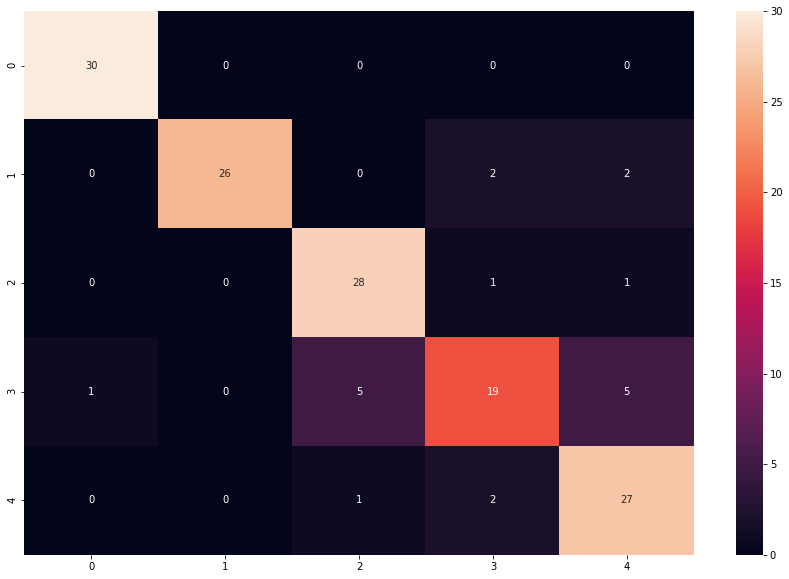

In [17]:

df_cm = pd.DataFrame(matrix,range(5), range(5))
plt.figure(figsize = (15,10))
sn.heatmap(df_cm, annot=True)
